## Assignment 1: Regression
Author:  Danis Alukaev \
Email: d.alukaev@innopolis.university \
Group: B19-DS-01

### Prerequisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning

### 2.1 Practical Task 1

#### Step 1: preprocess and visualize the dataset

In [2]:
# read both files
df1_partial = pd.read_csv('./task1_dataset.csv')
df1_full = pd.read_csv('./task1_dataset_full.csv')

In [3]:
# convert objects to pd.datetime type
df1_partial.loc[:, '0'].astype('datetime64[ns]')

# sort datetimes in ascending order
df1_partial.sort_values('0', inplace=True)
df1_full.sort_values('datetime', inplace=True)

# encode datetime column with integer values
df1_partial.loc[:, '0'] = np.linspace(0, len(df1_partial)-1, len(df1_partial), dtype=np.int64)
df1_partial = df1_partial.sort_index()

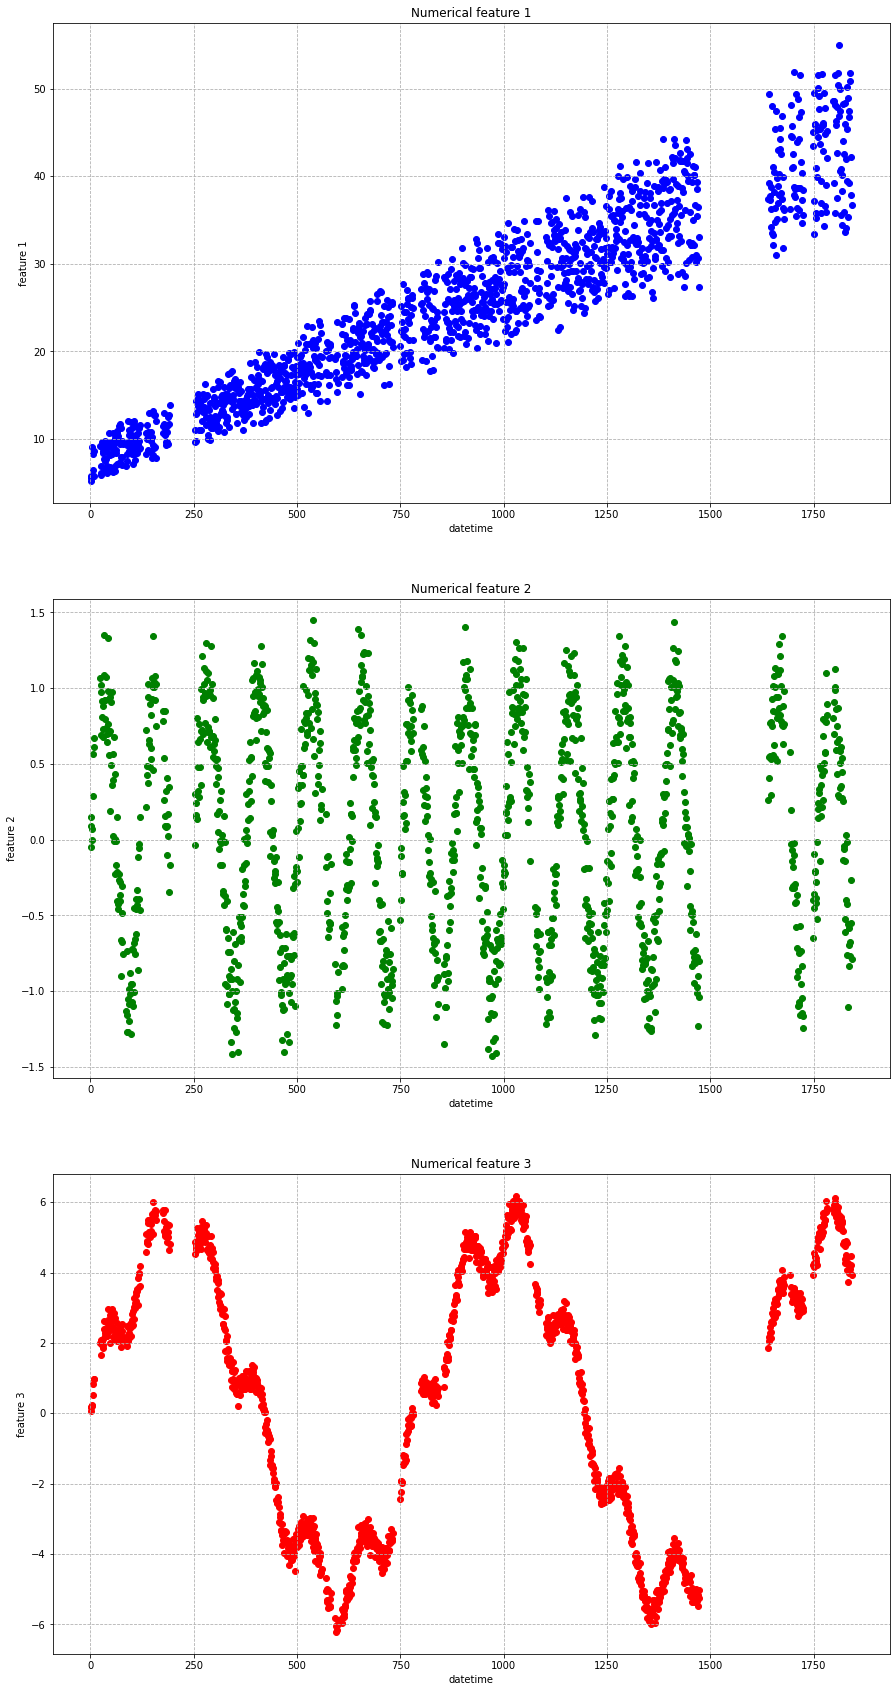

In [4]:
# plot features of the dataset
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,30))

ax1.title.set_text('Numerical feature 1')
ax1.grid(linestyle='--')
ax1.set_xlabel('datetime')
ax1.set_ylabel('feature 1')
ax1.scatter(df1_partial['0'], df1_partial['1'], c='b')

ax2.title.set_text('Numerical feature 2')
ax2.grid(linestyle='--')
ax2.set_xlabel('datetime')
ax2.set_ylabel('feature 2')
ax2.scatter(df1_partial['0'], df1_partial['2'], c='g')

ax3.title.set_text('Numerical feature 3')
ax3.grid(linestyle='--')
ax3.set_xlabel('datetime')
ax3.set_ylabel('feature 3')
ax3.scatter(df1_partial['0'], df1_partial['3'], c='r')

plt.show()

#### Step 2: apply different regression models for imputation

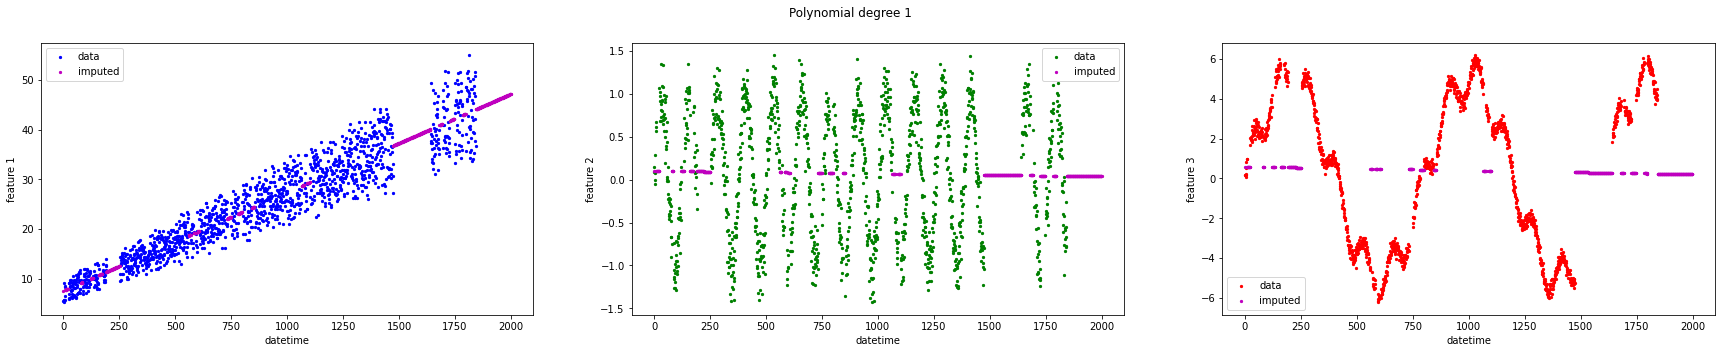

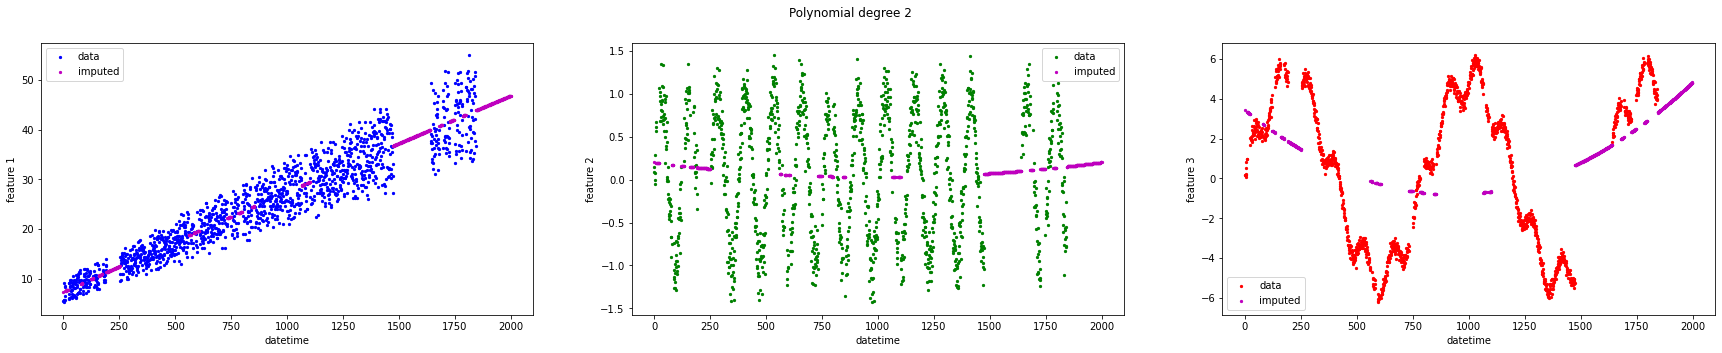

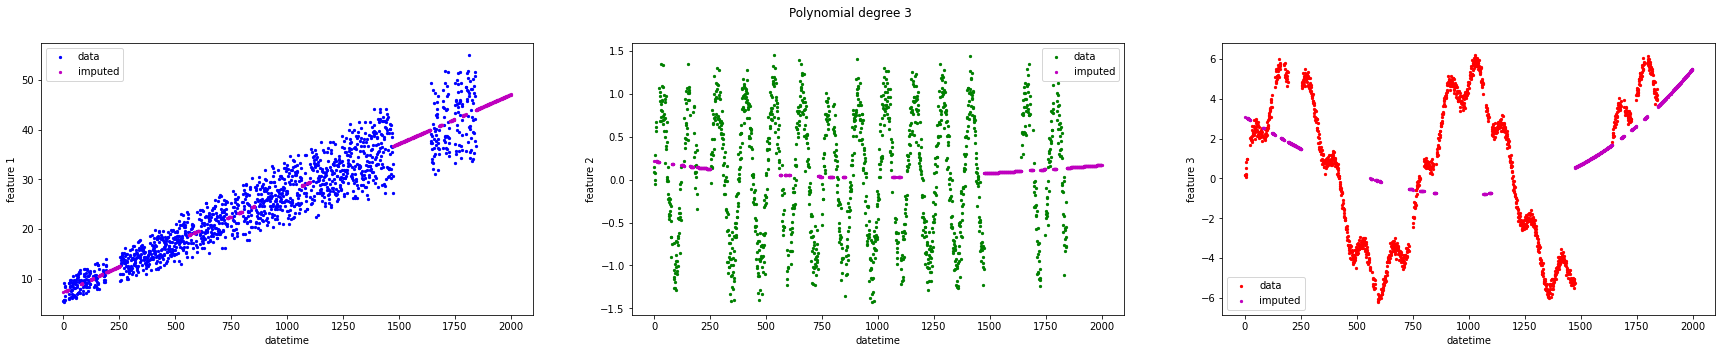

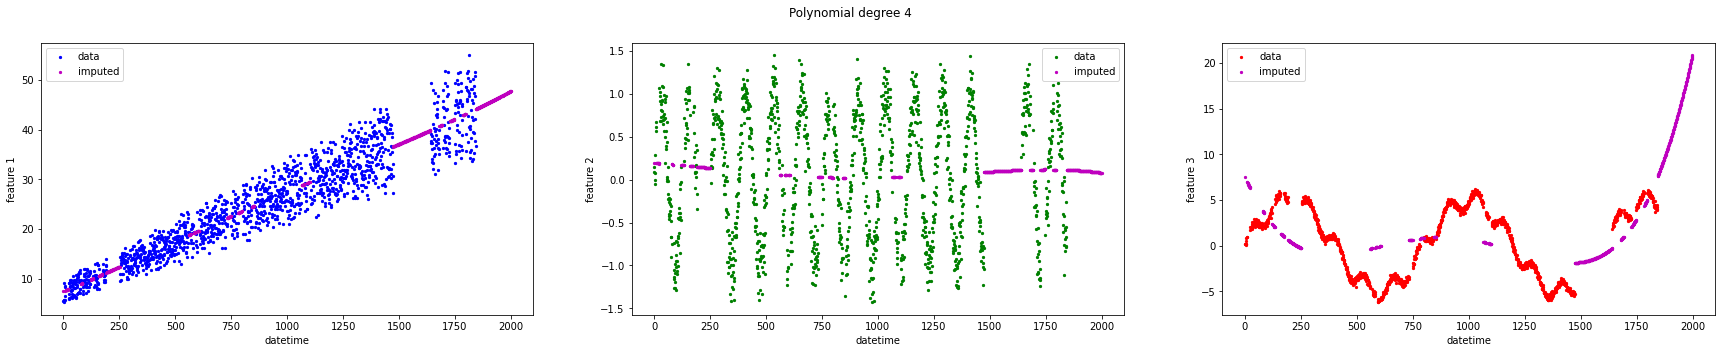

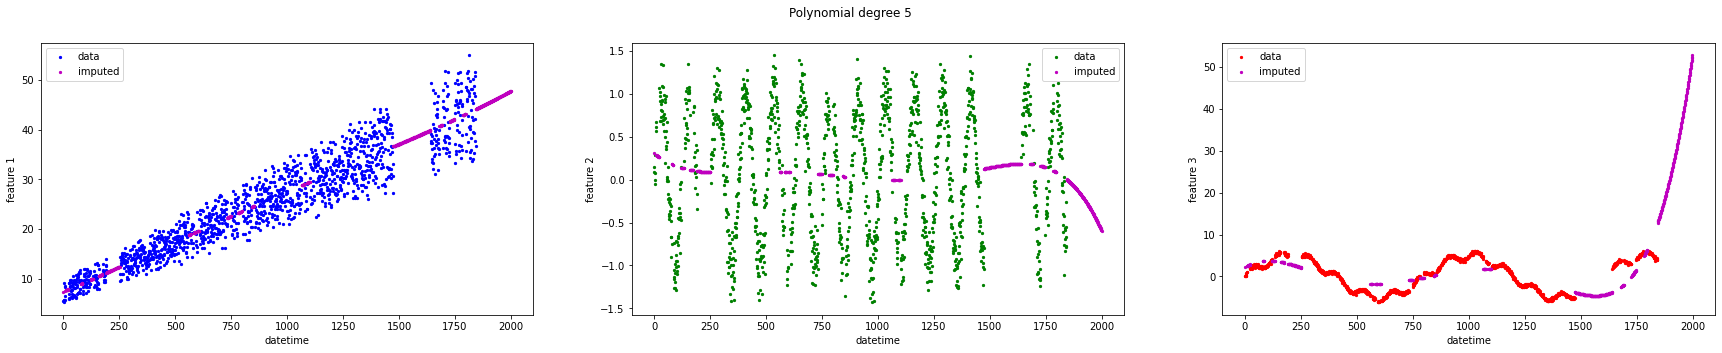

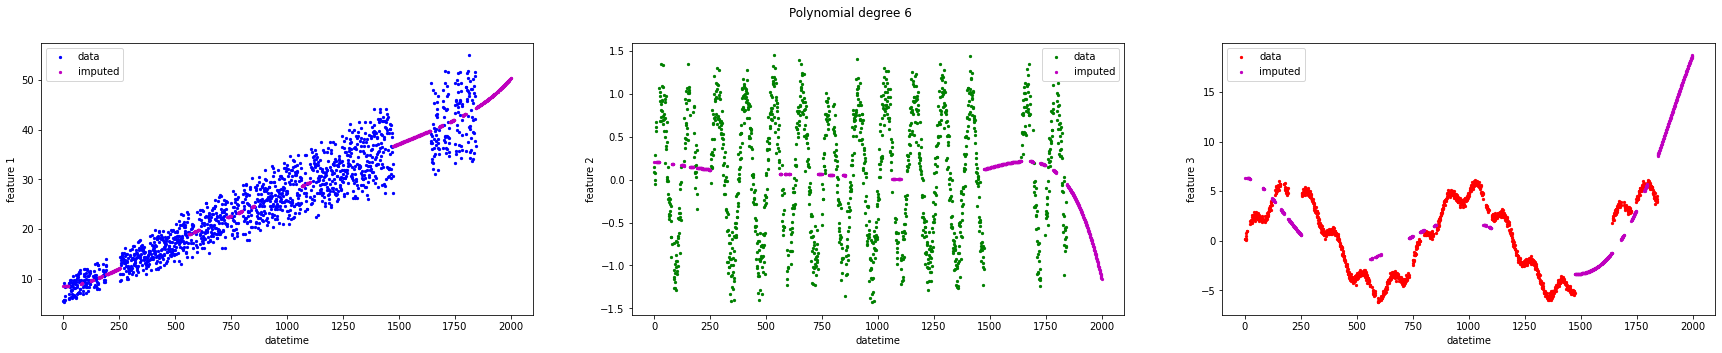

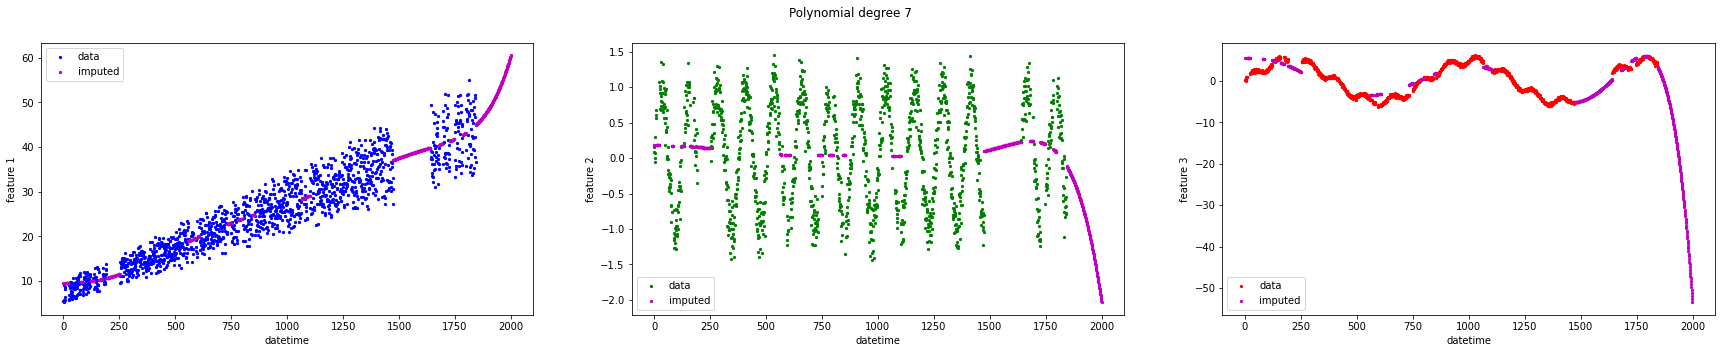

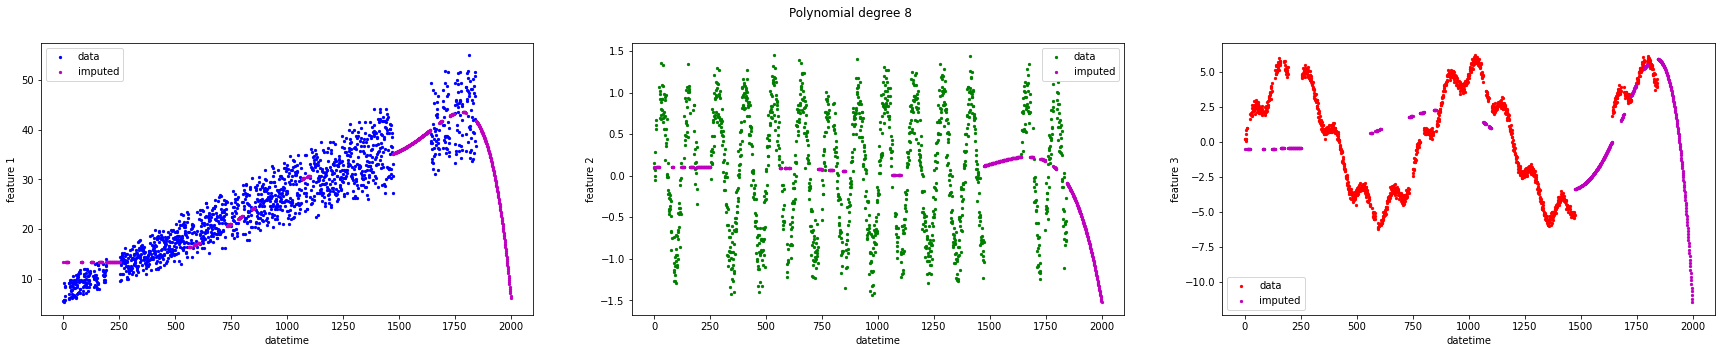

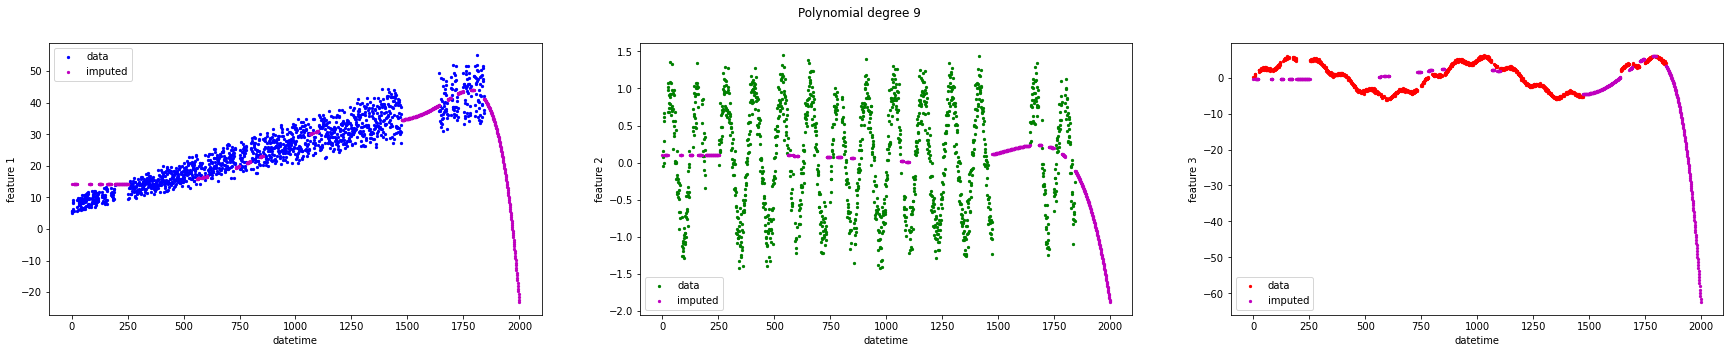

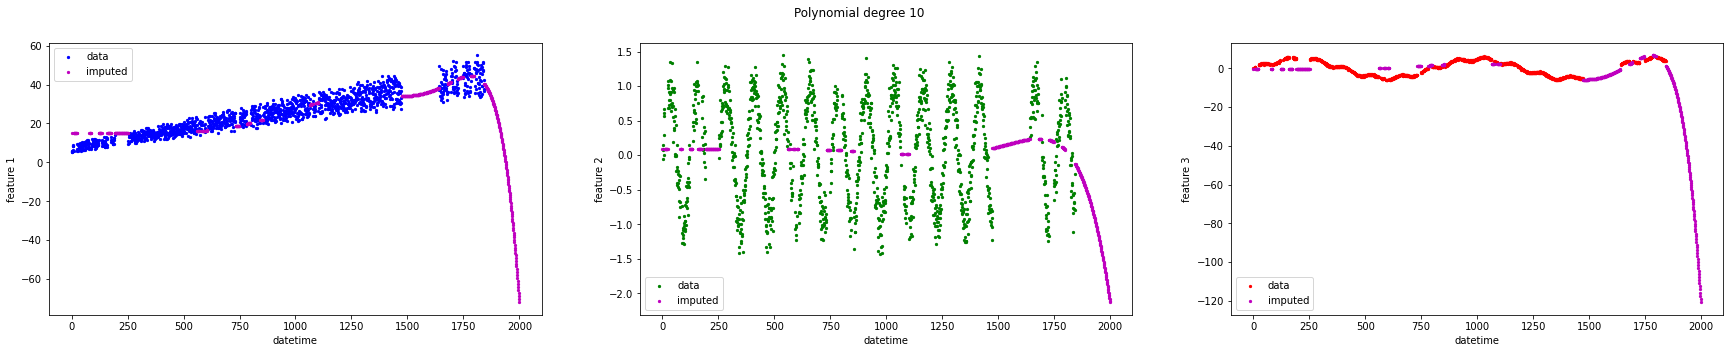

In [5]:
def apply_regression_model(x_train, y_train, x_test, degree):
    """
    Method applying regression model with specified degree to provided data.
    Creates pipeline incorporating 2 transforms: polynomial features and linear regression.
    Fits model with provided train set. 
    Predicts the result on test set.
    
    :param x_train: train features.
    :param y_train: train target variable.
    :param x_test: test features.
    :param degree: degree of polynomial.
    :return: 1d numpy array of predictions for test set.
    """
    pipeline = Pipeline([("polynomial_features", PolynomialFeatures(degree=degree)), 
                         ("linear_regression", LinearRegression()),
                        ])
    pipeline.fit(x_train[:, np.newaxis], y_train)
    pred = pipeline.predict(x_test[:, np.newaxis])
    return pred

def test_polynomial_degrees(df_partial, df_true, max_degree, plot=False):
    """
    Method evaluating regression models with different degrees from 1 up to the specified maximal degree.
    Splits dataset with missing data into the dataset for fitting ('df_train') and for testing ('df_nan').
    Iteratively applies regresstion model for all features. The prediction is 1d numpy array. 
    Plots the predictions if necessary.
    Fill predictions to the 'df_nan' and concatenate it with 'df_train' to obtain the imputed dataset.
    Computed Mean Squared Error (MSE) for imputed dataset and ground truth dataset.
    
    :param df_partial: dataset with missing data.
    :param df_true: ground truth dataset.
    :param max_degree: the upper bound for polynomial degree.
    :param plot: flag wether the predictions should be plotted.
    :return: np array of size (max_degree, 3) with MSE.
    """
    df_train, df_nan = df_partial.dropna(), df_partial[df_partial.isnull().any(axis=1)]
    
    degrees = np.linspace(1, max_degree, max_degree, dtype=np.int64)
    mse_degrees = np.zeros((max_degree, 3))
    
    for idx, degree in enumerate(degrees):
        # predict values for all features         
        prediction_f1 = apply_regression_model(df_train['0'].values, 
                                               df_train['1'].values, 
                                               df_nan['0'].values, 
                                               degree)

        prediction_f2 = apply_regression_model(df_train['0'].values, 
                                               df_train['2'].values, 
                                               df_nan['0'].values, 
                                               degree)

        prediction_f3 = apply_regression_model(df_train['0'].values, 
                                               df_train['3'].values, 
                                               df_nan['0'].values, 
                                               degree)
        
        # plot predictions         
        if plot:
            SCATTER_SIZE = 5
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,5))
            fig.suptitle(f"Polynomial degree {degree}")
            ax1.scatter(df1_partial['0'], 
                        df1_partial['1'], 
                        label='data', 
                        c='b', 
                        s=SCATTER_SIZE)
            
            ax1.scatter(df_nan['0'].values, 
                        prediction_f1, 
                        label='imputed', 
                        c='m', 
                        s=SCATTER_SIZE)
            
            ax1.legend()
            ax1.set_xlabel('datetime')
            ax1.set_ylabel('feature 1')
            
            ax2.scatter(df1_partial['0'], 
                        df1_partial['2'], 
                        label='data', 
                        c='g', 
                        s=SCATTER_SIZE)
            
            ax2.scatter(df_nan['0'].values, 
                        prediction_f2, 
                        label='imputed', 
                        c='m', 
                        s=SCATTER_SIZE)
            
            ax2.legend()
            ax2.set_xlabel('datetime')
            ax2.set_ylabel('feature 2')
            
            ax3.scatter(df1_partial['0'], 
                        df1_partial['3'], 
                        label='data',
                        c='r', 
                        s=SCATTER_SIZE)
            
            ax3.scatter(df_nan['0'].values, 
                        prediction_f3, 
                        label='imputed',
                        c='m', 
                        s=SCATTER_SIZE)
            
            ax3.legend()
            ax3.set_xlabel('datetime')
            ax3.set_ylabel('feature 3')
            
            plt.show()
        
        # fill the gaps with predicted values
        df_imputed_nan = df_nan.copy()
        df_imputed_nan[['1', '2', '3']] = np.hstack((prediction_f1[np.newaxis].T, prediction_f2[np.newaxis].T, prediction_f3[np.newaxis].T))
        df_imputed_entire = pd.concat([df_imputed_nan, df_train])
        df_imputed_entire.sort_values('0', inplace=True)
        
        # compute MSE for each feature          
        mse_degrees[idx] = np.array([mean_squared_error(df_imputed_entire.loc[:, '1'], df_true.loc[:, 'feature1']), 
                                     mean_squared_error(df_imputed_entire.loc[:, '2'], df_true.loc[:, 'feature2']), 
                                     mean_squared_error(df_imputed_entire.loc[:, '3'], df_true.loc[:, 'feature3'])
                                    ])
    return mse_degrees

MAX_DEGREE = 10
mse = test_polynomial_degrees(df1_partial, df1_full, MAX_DEGREE, plot=True)

In [6]:
# output MSE
print(mse)

[[2.07120912e+01 2.40781345e-01 3.14438763e+00]
 [2.07602534e+01 2.47391891e-01 2.54640156e+00]
 [2.07383566e+01 2.46140579e-01 2.68310519e+00]
 [2.07083245e+01 2.44500385e-01 1.36356146e+01]
 [2.07079441e+01 2.41398888e-01 7.46587302e+01]
 [2.07397047e+01 2.55904018e-01 1.26088882e+01]
 [2.31886085e+01 2.98895845e-01 4.73673322e+01]
 [5.53632093e+01 2.70849848e-01 3.43010920e+00]
 [1.11837145e+02 2.89422584e-01 6.33440226e+01]
 [2.60495162e+02 3.04102913e-01 2.33841984e+02]]


#### Step 3: plot MSE for each degree

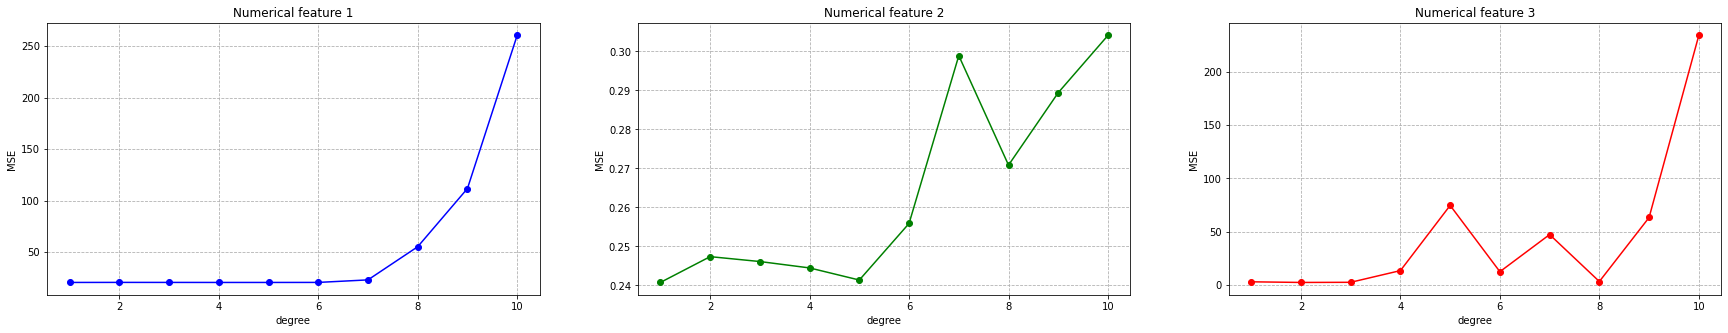

In [7]:
def plot_errors(errors):
    """
    Method plotting Mean Squared Errors (MSE) for all features.
    
    :param errors: MSE array of size (max_degrees, 3).
    """
    max_degree = errors.shape[0]
    degrees = np.linspace(1, max_degree, max_degree, dtype=np.int64)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,5))
    
    ax1.title.set_text('Numerical feature 1')
    ax1.grid(linestyle='--')
    ax1.set_xlabel('degree')
    ax1.set_ylabel('MSE')
    ax1.plot(degrees, errors[:, 0], '-o', c='b')

    ax2.title.set_text('Numerical feature 2')
    ax2.grid(linestyle='--')
    ax2.set_xlabel('degree')
    ax2.set_ylabel('MSE')
    ax2.plot(degrees, errors[:, 1], '-o', c='g')

    ax3.title.set_text('Numerical feature 3')
    ax3.grid(linestyle='--')
    ax3.set_xlabel('degree')
    ax3.set_ylabel('MSE')
    ax3.plot(degrees, errors[:, 2], '-o', c='r')
    
    plt.show()
    
plot_errors(mse)

#### Step 4: report best regression degree

In [8]:
# use argmin to find the degree yielding minimal MSE
print(f"The minimal MSE for numeric feature 1 is {mse[:, 0].min():.4f} with correspondent degree {np.argmin(mse[:, 0])+1}.")
print(f"The minimal MSE for numeric feature 2 is {mse[:, 1].min():.4f} with correspondent degree {np.argmin(mse[:, 1])+1}.")
print(f"The minimal MSE for numeric feature 3 is {mse[:, 2].min():.4f} with correspondent degree {np.argmin(mse[:, 2])+1}.")

The minimal MSE for numeric feature 1 is 20.7079 with correspondent degree 5.
The minimal MSE for numeric feature 2 is 0.2408 with correspondent degree 1.
The minimal MSE for numeric feature 3 is 2.5464 with correspondent degree 2.


<b>Report</b> 

During the experiments for each feature I have tested regressions with different polynomial degrees. \
The impact of each model was tested using MSE on the ground truth dataset. \
There were found that the minimal MSE for 
- feature 1 is 20.7079 with correspondent degree 5.
- feature 2 is 0.2408 with correspondent degree 1.
- feature 3 is 2.5464 with correspondent degree 2.

In the step 1, plots were built for each feature. It allows us to observe the data distribution and it is clear that the first one is more linear. Essentially, it means that we can approximate the value with small polynomials, where the difference in MSE will be insignificant. On the other hand, the second and third are alike to sigmoids and could be approximated by polynomials. 
Due to the reason that some data is missing in relatively big regions of domain, the regression model tend to overfit the data yielding lower score on validation stage. For instance, high order polynomials approximate some regions accuretly whereas on the missed part they behave unpredictably. 


#### Step 5: impute data!

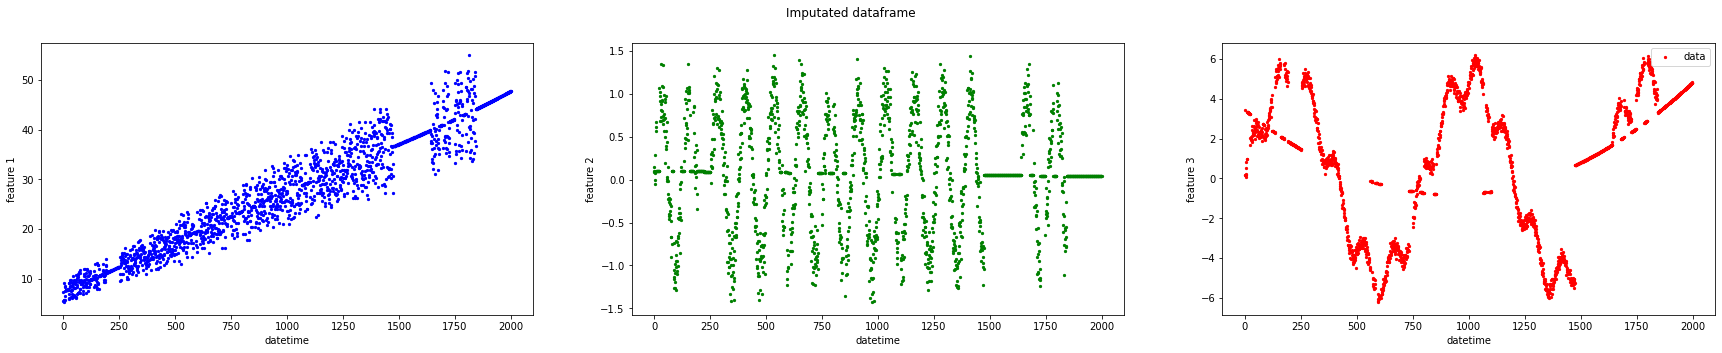

      Unnamed: 0     0          1         2         3
1999        1999     0   7.423657  0.101397  3.438017
1327        1327     1   5.525603  0.149548  0.188817
1973        1973     2   5.724147  0.089343  0.167879
1919        1919     3   5.226627 -0.050859  0.066940
605          605     4   5.648900  0.072186  0.229240
...          ...   ...        ...       ...       ...
1805        1805  1995  47.721773  0.039144  4.778574
1290        1290  1996  47.746282  0.039113  4.789040
1117        1117  1997  47.770809  0.039082  4.799515
592          592  1998  47.795355  0.039051  4.810000
267          267  1999  47.819919  0.039019  4.820495

[2000 rows x 5 columns]


In [9]:
def impute_data(df_partial, degree_f1, degree_f2, degree_f3, plot=False):
    """
    Method imputating given dataframe.
    Splits dataset with missing data into the dataset for fitting ('df_train') and for testing ('df_nan').
    Applies regresstion models for all features. 
    Fill predictions to the 'df_nan' and concatenate it with 'df_train' to obtain the imputed dataset.
    
    :param df_partial: dataset with missing data.
    :param degree_f1: polynomial degree for feature 1.
    :param degree_f2: polynomial degree for feature 2.
    :param degree_f3: polynomial degree for feature 3.
    :return: imputed dataframe.
    """
    df_train, df_nan = df_partial.dropna(), df_partial[df_partial.isnull().any(axis=1)]
    # predict values for all features         
    prediction_f1 = apply_regression_model(df_train['0'].values, 
                                           df_train['1'].values, 
                                           df_nan['0'].values, 
                                           degree_f1)

    prediction_f2 = apply_regression_model(df_train['0'].values, 
                                           df_train['2'].values, 
                                           df_nan['0'].values, 
                                           degree_f2)

    prediction_f3 = apply_regression_model(df_train['0'].values, 
                                           df_train['3'].values, 
                                           df_nan['0'].values, 
                                           degree_f3)
    # fill the gaps with predicted values
    df_imputed_nan = df_nan.copy()
    df_imputed_nan[['1', '2', '3']] = np.hstack((prediction_f1[np.newaxis].T, prediction_f2[np.newaxis].T, prediction_f3[np.newaxis].T))
    df_imputed_entire = pd.concat([df_imputed_nan, df_train])
    df_imputed_entire.sort_values('0', inplace=True)
    
    # plot predictions         
    if plot:
        SCATTER_SIZE = 5
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,5))
        fig.suptitle(f"Imputated dataframe")
        ax1.scatter(df_imputed_entire['0'], 
                    df_imputed_entire['1'], 
                    label='data', 
                    c='b', 
                    s=SCATTER_SIZE)
        ax1.set_xlabel('datetime')
        ax1.set_ylabel('feature 1')

        ax2.scatter(df_imputed_entire['0'], 
                    df_imputed_entire['2'], 
                    label='data', 
                    c='g', 
                    s=SCATTER_SIZE)
        ax2.set_xlabel('datetime')
        ax2.set_ylabel('feature 2')

        ax3.scatter(df_imputed_entire['0'], 
                    df_imputed_entire['3'], 
                    label='data',
                    c='r', 
                    s=SCATTER_SIZE)
        ax3.legend()
        ax3.set_xlabel('datetime')
        ax3.set_ylabel('feature 3')

        plt.show()
    
    return df_imputed_entire

# use observed degrees
df_imputed = impute_data(df1_partial, 5, 1, 2, plot=True)
print(df_imputed)

### Practical Task 2

In [10]:
# define set of feature names based on German dataset description
feature_names = ['checking_account', 
                 'duration', 
                 'credit_history',
                 'purpose', 
                 'credit_amount',
                 'savings', 
                 'present_employment', 
                 'installment_rate', 
                 'personal_status', 
                 'other_debtors', 
                 'present_residence', 
                 'property',              
                 'age', 
                 'installment_plans', 
                 'housing', 
                 'number_credits_bank', 
                 'job', 
                 'number_liable_people', 
                 'telephone', 
                 'foreign_worker', 
                 'approved']

# read file and set column names
df2 = pd.read_csv('./GermanData.csv', header=None, names=feature_names)

#### Step 1: preprocess and visualize dataset

To encode the categorical data there used one-hot and label techniques. \
The missing values were not found in the dataset, so no methods to imputate data were used.

In [11]:
# set of features to be encoded using one-hot method
features_onehot_enc = [
    ('checking_account', ['A11', 'A12', 'A13', 'A14']),
    ('credit_history', ['A30', 'A31', 'A32', 'A33', 'A34']), 
    ('purpose', ['A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A410']),
    ('savings', ['A61', 'A62', 'A63', 'A64', 'A65']),
    ('present_employment', ['A71', 'A72', 'A73', 'A74', 'A75']), 
    ('personal_status', ['A91', 'A92', 'A93', 'A94', 'A95']), 
    ('other_debtors', ['A101', 'A102', 'A103']),
    ('property', ['A121', 'A122', 'A123', 'A124']),
    ('installment_plans', ['A141', 'A142', 'A143']), 
    ('housing', ['A151', 'A152', 'A153']), 
    ('job', ['A171', 'A172', 'A173', 'A174'])
]

# set of features to be encoded using label method
features_label_enc = [
    ('telephone', ['A19']), 
    ('foreign_worker', ['A20'])
]


def apply_one_hot_encoder(df, categories, feature_names):
    """
    Method applying one hot encoding to values of a given dataframe.
    Fits the data in specified columns.
    Applies transformation to the data and name obtained columns according to the name of category.
    
    :param df: dataframe with data.
    :param categories: possible categories for each feature.
    :param feature_names: list of feature names.
    :return: dataframe with encoded columns.
    """
    encoder = OneHotEncoder(handle_unknown='ignore', categories=categories, sparse=False)
    encoder.fit(df[feature_names])

    features_encoded = encoder.transform(df[feature_names])
    flatten_categories = [category for category_group in categories for category in category_group]
    new_columns = pd.DataFrame(features_encoded, 
                               columns=flatten_categories, 
                               dtype=int)
    return new_columns

def apply_label_encoder(df, categories, feature_names):
    """
    Method applying label encoding to values of a given dataframe.
    For each feature name in provided list, fits data and applies transformation to the data.
    The obtained column named according to the name question id.
    
    :param df: dataframe with data.
    :param categories: possible categories for each feature.
    :param feature_names: list of feature names.
    :return: dataframe with encoded columns.
    """
    encoder = LabelEncoder()
    
    new_columns = []   
    for category, feature_name in zip(categories, feature_names):
        encoder.fit(df[feature_name])

        feature_encoded = encoder.transform(df[feature_name])
        new_column = pd.DataFrame(feature_encoded, 
                                   columns=category,
                                   dtype=int)
        new_columns.append(new_column)
        
    new_columns = pd.concat(new_columns, axis=1)
    return new_columns

def transform_categorical_values(df, categorical_features):
    """
    Method applying encoders for the specified features.
    Applies transformation to the data and update provided dataframe with the encoded data. 
    Currently supports one hot and label encoders.
    
    :param df: dataframe with data.
    :param categorical_features: list of tuples with the name of encoder and tuple of feature names and list of its possible attributes.
    :return: encoded columns.
    """
    new_df = df.copy()
    
    encoders = {'one-hot': apply_one_hot_encoder, 'label': apply_label_encoder}
    for type_enc, features in categorical_features:
        feature_names = [feature[0] for feature in features]
        categories = [feature[1] for feature in features]
        
        encoded = encoders[type_enc](df, categories, feature_names)
        new_df.drop(feature_names, axis=1, inplace=True)
        new_df = pd.concat([new_df, encoded], axis=1)
    return new_df
            
features_enc = [('one-hot', features_onehot_enc), ('label', features_label_enc)]
features_transformed = transform_categorical_values(df2, features_enc)
features_transformed['approved'] = features_transformed['approved'].map({1: 0, 2: 1})

<b>Discussion</b> \
In order to use PCA for data analysis, it is necessary to scale feature values. The PCA takes features with the highest variance. But the problem here is that features with a greater magnitude have greater variance. Accordingly, scaling features to certain range resolves that issue. \
There are several scalers considered including Robust Scaler and Standard Scaler. However, some values are negative. In my opinion, it does not make much sense for the given numeric features to be negative, all of them correspond to the non-negative value. Accordingly, for scaling I used min-max method because it maps values to range $[0..1]$.

In [12]:
numeric_features = ['duration', 
                    'credit_amount', 
                    'installment_rate', 
                    'present_residence', 
                    'age', 
                    'number_credits_bank',  
                    'number_liable_people']

def scale_numeric_features(df, feature_names):
    """
    Method scaling numeric features using min-max method.
    
    :param df: dataframe with data.
    :param feature_names: list of features to be scaled.
    :return: encoded columns.
    """
    scaler = MinMaxScaler()
    new_df = df.copy()
    new_df[feature_names] = scaler.fit_transform(new_df[feature_names])
    return new_df

features_scaled = scale_numeric_features(features_transformed, numeric_features)

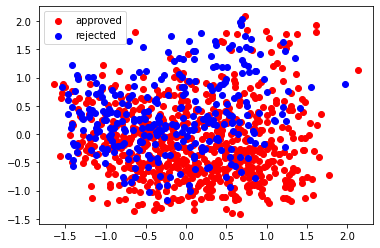

In [13]:
def visualize_dataset(df):
    """
    Method visualizing provided dataset.
    Applies PCA with two components to the dataset.
    Plot obtained components for approved and rejected cases independently.
    
    :param df: dataframe with data.
    """
    # columns without target variable     
    features = df[df.columns.drop('approved')]
         
    pca = PCA(n_components=2)
    components = pca.fit_transform(features)
    components = pd.DataFrame(data = components, columns = ['1', '2'])
    
    # correspondence of approved and rejected to values 1 and 2 taken from 'Data Set Information' section of
    # https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)  
    indices_approved = df.index[df['approved'] == 0]
    indices_rejected = df.index[df['approved'] == 1]
    
    plt.scatter(components['1'][indices_approved], components['2'][indices_approved], label='approved', c='r')
    plt.scatter(components['1'][indices_rejected], components['2'][indices_rejected], label='rejected', c='b')
    plt.legend()
    plt.show()

features_scaled_without_target = features_scaled[features_scaled.columns.drop('approved')]
visualize_dataset(features_scaled)

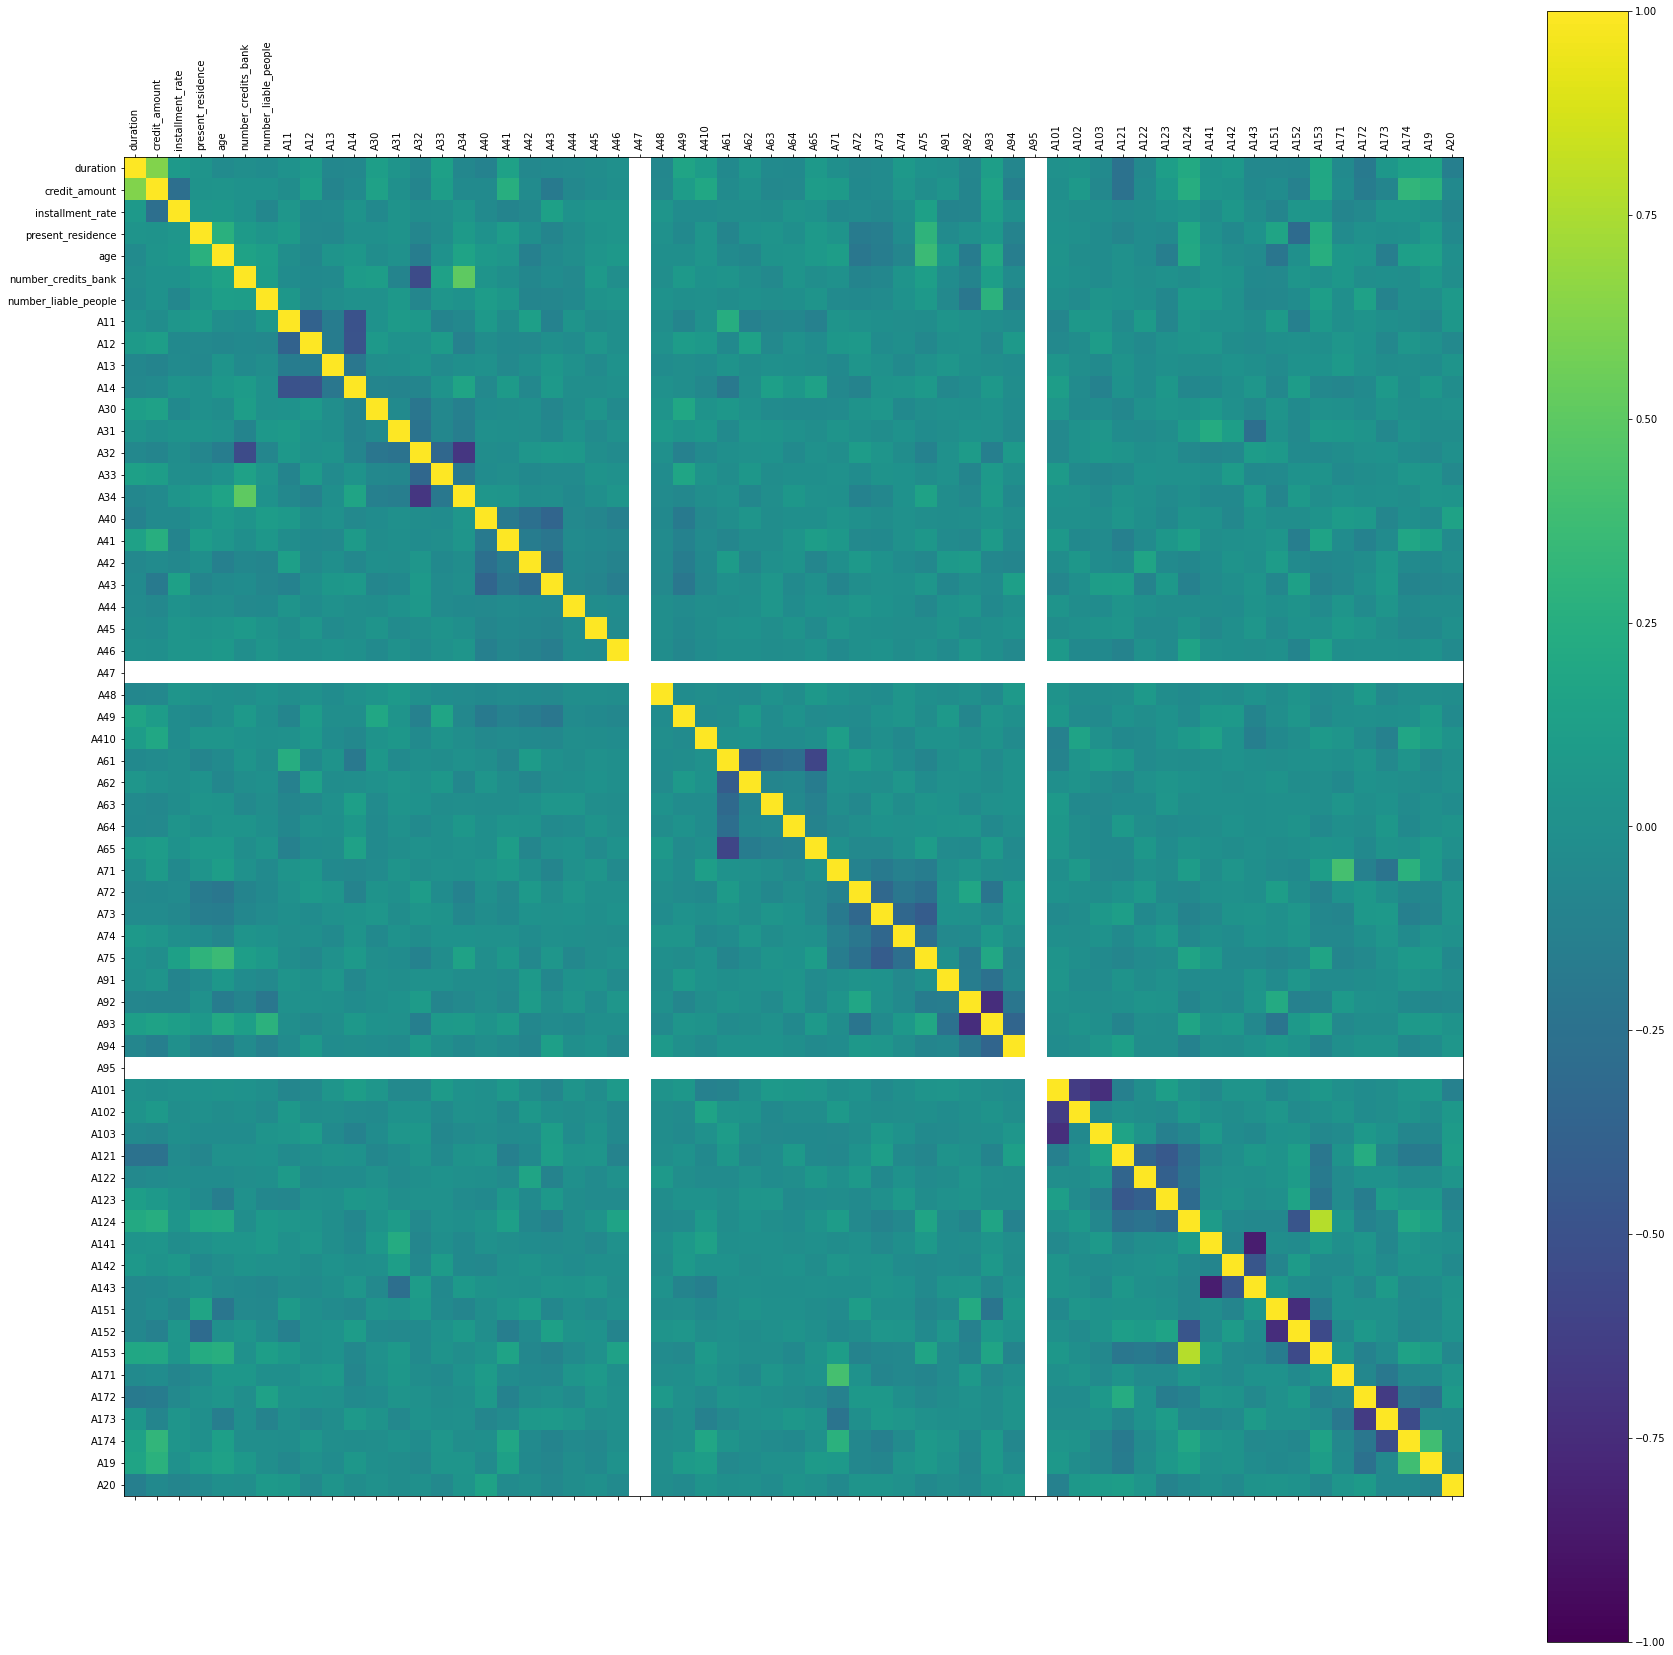

In [14]:
def plot_correlation_matrix(df):
    """
    Method plotting correalation matrix for dataset.
    
    :param df: dataframe with data.
    :return: correlation matrix.
    """
    # columns without target variable     
    features = df[df.columns.drop('approved')]
    correlation_matrix = features.corr()
    
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111)
    axes = ax.matshow(correlation_matrix, vmin=-1, vmax=1)
    fig.colorbar(axes)
    
    # set up x and y ticks     
    ticks = np.arange(0, correlation_matrix.shape[0], 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(correlation_matrix.columns,rotation=90)
    ax.set_yticklabels(correlation_matrix.columns)
    
    plt.show()
    return correlation_matrix

correlation_matrix = plot_correlation_matrix(features_scaled)

In [15]:
THRESHOLD = 0.5

def get_highly_correlated_features(df, correlation_matrix, threshold):
    """
    Method printing highly correlated features based on provided threshold.
    
    :param df: dataframe with data.
    :param correlation_matrix: correlation matrix for df.
    :param threshold: threshold.
    """    
    indices = np.argwhere((np.array(correlation_matrix) > threshold) | (np.array(correlation_matrix) < -threshold))
    columns = df.columns.tolist()
    
    filtered_indices = []
    for index in indices:
        # filter elements on main diagonal and symmetric     
        if index[0] != index[1] and index[::-1].tolist() not in filtered_indices:
            filtered_indices.append(index.tolist())
            
    print("Highly correlated features:\n")
    for idx, index in enumerate(filtered_indices):
        print(f"{idx + 1}. Features '{columns[index[0]]}' and '{columns[index[1]]}'. Correlation: {np.array(correlation_matrix)[index[0], index[1]]:.2f}.")

get_highly_correlated_features(features_scaled, correlation_matrix, THRESHOLD)

Highly correlated features:

1. Features 'duration' and 'credit_amount'. Correlation: 0.62.
2. Features 'number_credits_bank' and 'A31'. Correlation: -0.54.
3. Features 'number_credits_bank' and 'A33'. Correlation: 0.50.
4. Features 'A31' and 'A33'. Correlation: -0.68.
5. Features 'A410' and 'A64'. Correlation: -0.58.
6. Features 'A91' and 'A92'. Correlation: -0.74.
7. Features 'A95' and 'A101'. Correlation: -0.65.
8. Features 'A95' and 'A102'. Correlation: -0.73.
9. Features 'A123' and 'A152'. Correlation: 0.78.
10. Features 'A124' and 'A142'. Correlation: -0.84.
11. Features 'A143' and 'A151'. Correlation: -0.74.
12. Features 'A151' and 'A152'. Correlation: -0.55.
13. Features 'A171' and 'A172'. Correlation: -0.65.
14. Features 'A172' and 'A173'. Correlation: -0.54.


<b>Discussion</b> \
Using the function above there were found 14 pairs of highly correlated features (see output above). 

For example, features `A123` and `A152` with correlation 0.78. `A123` stands for owning car or other, whereas `A152` stands for owning the house. Indeed, people who have a house are very likely to also have other property such as a car, so such phenomena are logically justified.

The high correlated features are not necessary problem for regression task. Ideally, regression should be performed on data with independent features. It allows to find such regression coefficients that represent the change in target variable for unit of feature with other feature values constant. However, when model deals with correlated features it become impossible to find this change independently from other features, i.e. change associated with the shifts of other features. As a result, model fails to find good relationship between the feature values and the target variable.

#### Step 2: split dataset

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    features_scaled[features_scaled.columns.drop('approved')], 
    features_scaled['approved'], 
    test_size=0.3, 
    random_state=42)

#### Step 3: apply logistic regression

In [17]:
"""
The standard parameter for max_iter is 100 in LogisticRegression class.
Sometimes solver does not converge for these 100 iterations.
To notify us, sklearn throws warnings that which take up a lot of space.
I decided to ignore them not to clog the notebook.
"""
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [18]:
numeric_features = ['duration', 
                    'credit_amount', 
                    'installment_rate', 
                    'present_residence', 
                    'age', 
                    'number_credits_bank',  
                    'number_liable_people']

def apply_log_regression(x_train, y_train, x_test, y_test, numeric_features, degree):
    """
    Method applying logistic regression to input datasets.
    Creates column transformer object to apply polynomial features only to numeric features.
    Creates pipeline with columns transformer and logistic regression.
    Fits model with provided train set. 
    Predicts the result on test set.    
    
    :param x_train: train dataset with features.
    :param y_train: train dataset with targer variable.
    :param x_test: test dataset with features.
    :param y_test: test dataset with targer variable.
    :param numeric_features: list of names of numeric features.
    :param degree: polynomial degree.
    :return: np array with train and test errors.
    """    
    transformer = ColumnTransformer([
        ("poly", PolynomialFeatures(degree=degree), numeric_features)
    ], remainder='passthrough')
    
    pipeline = Pipeline([("trans", transformer), ("log", LogisticRegression())])
    pipeline.fit(x_train, y_train)

    train_error = log_loss(y_train, pipeline.predict_proba(x_train))
    test_error = log_loss(y_test, pipeline.predict_proba(x_test))
    
    train_acc = accuracy_score(pipeline.predict(x_train), y_train)
    test_acc = accuracy_score(pipeline.predict(x_test), y_test)
    
    return(np.array([[train_error, test_error], [train_acc, test_acc]]))


def test_polynomial_degrees(x_train, y_train, x_test, y_test, numeric_features, max_degree):
    """
    Method testing regression model with different polynomial degrees.
    
    :param x_train: train dataset with features.
    :param y_train: train dataset with targer variable.
    :param x_test: test dataset with features.
    :param y_test: test dataset with targer variable.
    :param numeric_features: list of names of numeric features.
    :param max_degree: the upper bound for polynomial degree.
    :return: np array of size (max_degree, 2) with train and test errors.
    """    
    degrees = np.linspace(1, max_degree, max_degree).astype(np.int64)
    metrics = np.zeros((max_degree, 2, 2))
    
    for idx, degree in enumerate(degrees):
        metrics[idx] = apply_log_regression(x_train, y_train, x_test, y_test, numeric_features, degree)
    return metrics

MAX_DEGREE = 10
metrics = test_polynomial_degrees(x_train, y_train, x_test, y_test, numeric_features, MAX_DEGREE)

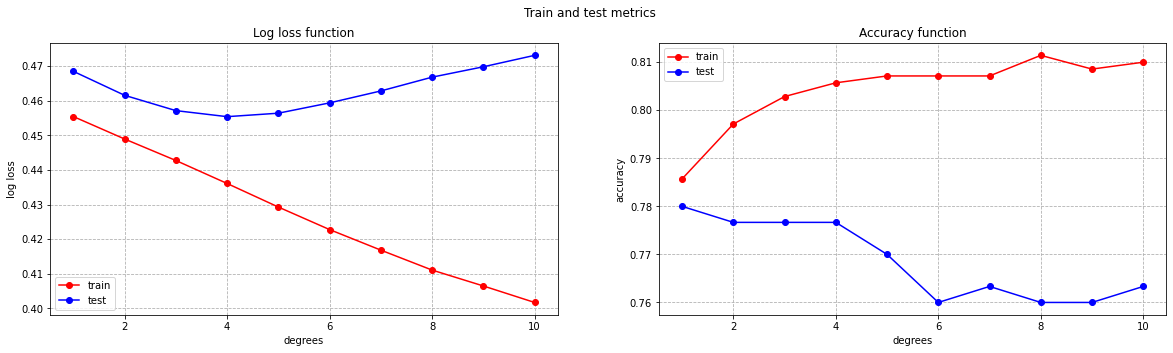

In [19]:
def plot_errors(errors):
    """
    Method plotting log loss errors for train and test datasets.
    
    :param errors: np array of size (max_degree, 2), first column is train error, second - test.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle("Train and test metrics")
    degrees = np.linspace(1, 10, 10).astype(np.int64)
    
    ax1.set_title("Log loss function")
    ax1.plot(degrees, errors[:,0,0], '-o', c='r', label='train')
    ax1.plot(degrees, errors[:,0,1], '-o', c='b', label='test')
    ax1.set_xlabel('degrees')
    ax1.set_ylabel('log loss')
    ax1.legend()
    ax1.grid(linestyle='--')
    
    
    
    ax2.set_title("Accuracy function")
    ax2.plot(degrees, errors[:,1,0], '-o', c='r', label='train')
    ax2.plot(degrees, errors[:,1,1], '-o', c='b', label='test')
    ax2.set_xlabel('degrees')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(linestyle='--')

    plt.show()

plot_errors(metrics)

In [20]:
min_idx_loss = np.argmin(metrics[:, 0, 1])
DEGREE = min_idx_loss+1

print(f"The best model in terms of log loss is {min_idx_loss+1} with correspondent log loss: train={metrics[min_idx_loss, 0, 0]:.4f}, test={metrics[min_idx_loss, 0, 1]:.4f}.")

The best model in terms of log loss is 4 with correspondent log loss: train=0.4361, test=0.4554.


<b>Discussion</b> \
From the log loss plot, we can conclude that the optimal degree of polynomial is 4. It has least test loss and tolerable train loss. All the degrees from right of 4 (5-10) will correspond to overfitting whereas all degrees to the left (1-3) to underfitting. Consider the extreme cases:

The model with degree 1 tend to underfit the data. The training error is maximal and test error still great indicating that the model badly generalize the train data and poorly generalize the test set. 

Consider the model with degree 10: the train error is minimal, but the test error is insufficiently small meaning that the model overfits.

#### Step 4: fine-tune models hyperparamaters

In [21]:
numeric_features = ['duration', 
                    'credit_amount', 
                    'installment_rate', 
                    'present_residence', 
                    'age', 
                    'number_credits_bank',  
                    'number_liable_people']

parameters = [{'log__penalty': ['l2'], 
               'log__solver': ['lbfgs'], 
               'log__C': np.logspace(-4, 4, 20)
              },
              {'log__penalty': ['l1', 'l2'], 
               'log__solver': ['liblinear'], 
               'log__C': np.logspace(-4, 4, 20)
              }
]
    
def fine_tune_params(x_test, y_test, numeric_features, parameters, degree):
    """
    Method that fine-tune parameters of the model with given degree.
    Creates Grid Searcher that validates model with different parameters.
    Fits test sets and search in parameters.
    
    :param x_test: set of features.
    :param y_test: set of target variables.
    :param numeric_features: list of numeric feature names.
    :param parameters: parameters to be tested.
    :param degree: degree of polynomial.
    :return: dictionary with parameters yielding best result.
    """
    transformer = ColumnTransformer([("poly", PolynomialFeatures(degree=degree), numeric_features)], remainder='passthrough') 
    pipeline = Pipeline([("trans", transformer), ("log", LogisticRegression())])
    grid_searcher = GridSearchCV(pipeline, parameters)
    grid_searcher.fit(x_test, y_test)
    
    print(grid_searcher.best_score_)
    print(grid_searcher.best_params_)
    return grid_searcher.best_params_
    
best_parameters = fine_tune_params(x_train, y_train, numeric_features, parameters, 1)

0.7428571428571429
{'log__C': 0.08858667904100823, 'log__penalty': 'l2', 'log__solver': 'lbfgs'}


In [22]:
def create_optimal_pipeline(x_train, y_train, C, penalty, solver, degree):
    """
    Method creating model with given parameters. 
    Fits train data and returns model.
    
    :param x_train: train set of features.
    :param y_train: train set of target variables.
    :param C: inverse of regularization strength.
    :param penalty: penalty parameter for Logistic Regression.
    :param solver: solver typer for Logistic Regression.
    :param degree: degree.
    :return: model.
    """
    transformer = ColumnTransformer([("poly", PolynomialFeatures(degree=degree), numeric_features)], remainder='passthrough') 
    pipeline = Pipeline([("trans", transformer), ("log", LogisticRegression(C=C, penalty=penalty, solver=solver))])
    pipeline.fit(x_train, y_train)
    return pipeline
    

model = create_optimal_pipeline(x_train, 
                                y_train,
                                best_parameters['log__C'], 
                                best_parameters['log__penalty'],
                                best_parameters['log__solver'],
                                DEGREE
                               )

#### Step 5: compare the accuracy of predictions across male and female applicants

In [23]:
def split_set_by_sex(dataset):
    """
    Method splitting given dataset by gender.
    The gender information is incorporated in attribut A9.

    :param dataset: dataset to be tested.
    :return: sets of attributes and target variables of men, women.
    """
    men_set = dataset[(dataset['A91'] == 1) | 
                       (dataset['A93'] == 1) | 
                       (dataset['A94'] == 1)]
    men_x, men_y = men_set[men_set.columns.drop('approved')], men_set['approved']

    women_set = dataset[(dataset['A92'] == 1) | 
                        (dataset['A95'] == 1)]
    women_x, women_y = women_set[women_set.columns.drop('approved')], women_set['approved']
    return men_x, women_x, men_y, women_y


test_set = pd.concat([x_test, y_test], axis=1)
men_x, women_x, men_y, women_y = split_set_by_sex(test_set)

In [24]:
men_acc = accuracy_score(model.predict(men_x), men_y)
women_acc = accuracy_score(model.predict(women_x), women_y)

print(f"Accuracy for men is {men_acc:.4f} vs. {women_acc:.4f} for women.")

Accuracy for men is 0.7783 vs. 0.7614 for women.


<b>Discussion</b> \
The accuracies of fine-tuned model for men and women on the test set are very close: the difference is 1.7%. The reason for that is the propotion of men and women in train and test datasets. The ratio of women to men is 1 to 2.41 in the test set and 1 to 2.23 on whole set. \
In addition, it is important that the ratio of the number of cases of approval of a loan application to refusals was the same for men and women in the test set and the whole set. The ratio of women to men approvals is 1 to 2.54 in the test set and 1 to 2.48 on whole set. \
Thus, we preserve the original distribution of cases and do not allow even more bias among genders.

In [26]:
men_set_whole = features_scaled[(features_scaled['A91'] == 1) | 
                          (features_scaled['A93'] == 1) | 
                          (features_scaled['A94'] == 1)]

women_set_whole = features_scaled[(features_scaled['A92'] == 1) | 
                          (features_scaled['A95'] == 1) ]

print(f"The ratio of women to men is 1 to {len(men_x)/len(women_x):.2f} in the test set and 1 to {len(men_set_whole)/len(women_set_whole):.2f} on whole set.")

The ratio of women to men is 1 to 2.41 in the test set and 1 to 2.23 on whole set.


In [27]:
men_whole_approved = men_set_whole[(men_set_whole['approved'] == 0)]
women_whole_approved = women_set_whole[(women_set_whole['approved'] == 0)]
men_test_approved = men_y[(men_y == 0)]
women_test_approved = women_y[(women_y == 0)]

print(f"The ratio of women to men approvals is 1 to {len(men_test_approved)/len(women_test_approved):.2f} in the test set and 1 to {len(men_whole_approved)/len(women_whole_approved):.2f} on whole set.")

The ratio of women to men approvals is 1 to 2.54 in the test set and 1 to 2.48 on whole set.
